# Learn to reach a pose

We move to a slightly more complex task: reaching a pose from a random initial pose.
This task introduces a success criterion: an agent is successful if it reaches the pose (within some tolerance) before the timeout expires.

We are going to evalutate success, together with reward and episode length, during and after training. 

In [1]:
import warnings
warnings.filterwarnings("ignore")

## The scenario

We define a scenario where the agent starts randomly and wants to reach the origin.

In [2]:
from navground import sim, core
import math

duration = 20.0
time_step = 0.1
     
scenario = sim.load_scenario("""
bounding_box:
    min_x: -5
    max_x: 5
    min_y: -5
    max_y: 5
groups:
  -
    type: thymio
    number: 1
    radius: 0.5
    control_period: 0.1
    color: goldenrod
    kinematics:
      type: 2WDiff
      wheel_axis: 1
      max_speed: 1
      max_backward_speed: 1
      max_forward_speed: 1
    position:
      sampler: uniform
      from: [-5, -5]
      to: [5, 5]
      # value: [1, 1]
    orientation:
      sampler: uniform
      from: 0
      to: 6.28
    behavior:
      type: Dummy
    task:
      type: GoToPose
      angular_tolerance: 0.25
      tolerance: 0.25
      orientation: 0
      point: [0, 0]
""")

We display the target pose in grey. 

As there are no obstacles, the dummy behavior reaches the target pose successfully within the prefixed tolerance of 0.25 meters and 0.25 radians.

In [3]:
from navground.sim.ui.to_svg import svg_for_agent
from navground.sim.ui.video import display_video_from_run

def draw_target(world: sim.World) -> str:
    r = ''
    for agent in world.agents:
        if agent.behavior:
            target = sim.Agent(radius=agent.radius)
            target.type = agent.type
            pose = agent.behavior.get_target_pose(core.Frame.absolute, ignore_tolerance=True)
            if pose:
                target.pose
                r +=  svg_for_agent(target, attributes={'fill': 'grey'})
    return r


exp = sim.Experiment(time_step=time_step, steps=200)
exp.scenario = scenario
exp.record_config.pose = True
exp.terminate_when_all_idle_or_stuck = True
display_video_from_run(exp.run_once(seed=4), factor=4, display_width=300, 
                       background_extras=[draw_target])

## The environment

We make the agent controls its linear and angular accelerations.

In [4]:
from navground.learning import ControlActionConfig

action_config = ControlActionConfig(max_acceleration=1, 
                                    max_angular_acceleration=10, 
                                    use_acceleration_action=True)

using information about its own velocity and target

In [5]:
from navground.learning import DefaultObservationConfig

observation_config = DefaultObservationConfig(
    include_velocity=True, include_angular_speed=True,
    include_target_direction=True, include_target_distance=True, 
    include_target_orientation=True)

We assign a reward that promote moving towards the target pose at full speed and then stop when within the tolerance. We also specify how success is defined: the agent should reach the target and have a low enough velocity. 

In [6]:
import gymnasium as gym
from navground.learning.rewards import TargetEfficacyReward

def is_success(agent: sim.Agent, world: sim.World) -> bool:
    return (world.step > 0 and agent.behavior.check_if_target_satisfied() and 
            agent.behavior.is_stopped(epsilon_speed=0.01, epsilon_angular_speed=0.1))

train_env = gym.make('navground',
    scenario=scenario,
    action=action_config,
    observation=observation_config,
    reward=TargetEfficacyReward(),
    time_step=time_step,
    max_duration=duration,
    success_condition=is_success,
    terminate_on_success=True,
    init_success=False)

It is a good practice to introduce a separate enviroment for testing. In our case, StableBaseline3 
requires a vectorized enviroment.

In [7]:
from stable_baselines3.common.vec_env import DummyVecEnv

test_venv = DummyVecEnv([
    lambda: gym.make('navground',
                     scenario=scenario,
                     action=action_config,
                     observation=observation_config,
                     reward=TargetEfficacyReward(),
                     time_step=time_step,
                     max_duration=duration,
                     success_condition=is_success,
                     terminate_on_success=True,
                     init_success=False) for _ in range(1)])
test_venv.seed(1);

In [8]:
from navground.learning.evaluation import evaluate_policy

dummy_policy = train_env.unwrapped.policy
dummy_reward, dummy_reward_std_dev = evaluate_policy(dummy_policy, test_venv, n_eval_episodes=100)
print(f"Dummy reward = {dummy_reward:.2f} ± {dummy_reward_std_dev:.2f}")

Dummy reward = -16.84 ± 4.34


In [9]:
from navground.learning.policies.random_predictor import RandomPredictor

random_policy = RandomPredictor(action_space=dummy_policy.action_space, 
                                observation_space=dummy_policy.observation_space)
random_reward, random_reward_std_dev = evaluate_policy(random_policy, test_venv, n_eval_episodes=100)
print(f"Random reward = {random_reward:.2f} ± {random_reward_std_dev:.2f}")

Random reward = -199.94 ± 4.57


## Training

We train a RL policy using StableBaseline3 SAC algorithm.

In [10]:
from stable_baselines3 import SAC
sac = SAC("MultiInputPolicy", train_env, verbose=0, policy_kwargs={'net_arch': [32, 32]})

We configure StableBaseline3 logs to save a CSV file.

In [11]:
from stable_baselines3.common.logger import configure
from pathlib import Path
from datetime import datetime as dt

stamp = dt.now().strftime("%Y%m%d_%H%M%S")
sac.set_logger(configure(f"logs/Pose/SAC/{stamp}", ["csv"]))
path = Path(sac.logger.get_dir())
path

PosixPath('logs/Pose/SAC/20250520_155144')

We add callbacks to perform evaluation using the test enviroment we just created (and automatically export the best model to onnx),

In [12]:
from navground.learning.utils.sb3 import callbacks

cbs = callbacks(test_venv, sac.logger.get_dir(), eval_freq=2_000, 
                number_of_videos=0, export_to_onnx=True)

while we train

In [13]:
sac.learn(total_timesteps=40_000, reset_num_timesteps=False, log_interval=30,
          callback=cbs)
sac.num_timesteps

  0%|          | 0/40000 [00:00<?, ?it/s]

40000

We check the evaluation logs. We see that the policy performs well (i.e., sightly better then Dummy) from about 25K steps. 

In [ ]:
import pandas as pd
from navground.learning.utils.sb3 import load_eval_logs, plot_eval_logs

pd.set_option("display.precision", 2)

load_eval_logs(path)

,time/total_timesteps,eval/mean_ep_length,eval/mean_reward,eval/success_rate
0,2000,200.00,-194.58,0.00
1,4000,200.00,-179.77,0.00
2,6000,200.00,-172.55,0.00
4,8000,158.40,-83.64,0.63
5,10000,159.17,-64.84,0.40
7,12000,91.27,-51.03,0.97
9,14000,120.90,-83.46,0.83
10,16000,174.43,-142.54,0.23
12,18000,130.23,-92.74,0.57
13,20000,200.00,-55.89,0.00


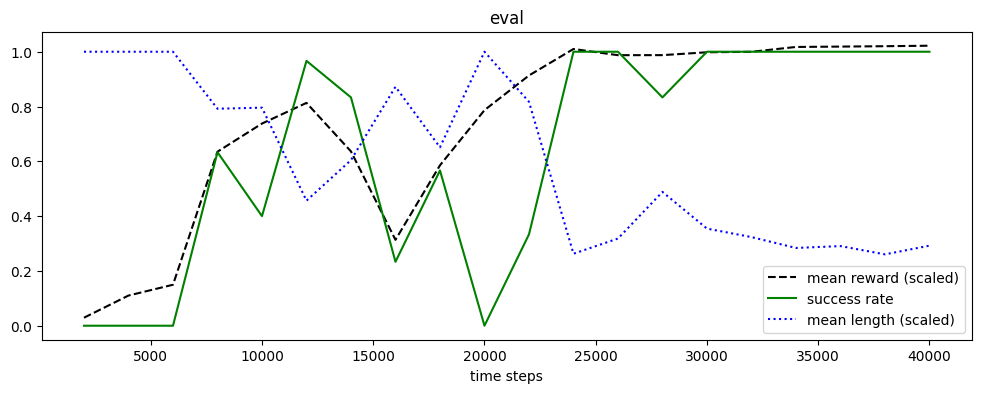

In [15]:
plot_eval_logs(path, success=True, length=True, reward_high=dummy_reward, reward_low=random_reward, 
               length_high=200, figsize=(12, 4))

## Evaluation

We now evaluate the policy using navground experiments, which allow to record any kind of data, included success, which is not possible using `evalutate_policy`.

In [16]:
from navground.learning.evaluation.experiment import make_experiment_with_env
import numpy as np

exp = make_experiment_with_env(test_venv)
exp.terminate_when_all_idle_or_stuck = True
exp.record_config.pose = True
exp.number_of_runs = 1000
exp.steps = 200
exp.run()

reward = [np.sum(run.records['reward']) for run in exp.runs.values()]
length = [len(run.records['reward']) for run in exp.runs.values()]
# Success is not recorded for the navground policy
success = np.mean([x < 200 for x in length])

df = pd.DataFrame()
df['expert'] = {'success rate': success, 
                'mean reward': np.mean(reward), 'std dev reward': np.std(reward),
                'mean length': np.mean(length), 'std dev length': np.std(length)}

In [17]:
exp = make_experiment_with_env(test_venv, policy=random_policy)
exp.terminate_when_all_idle_or_stuck = True
exp.number_of_runs = 100
exp.record_config.pose = True
exp.steps = 200
exp.run()

success = np.mean([np.sum(run.records['success']) for run in exp.runs.values()])
reward = [np.sum(run.records['reward']) for run in exp.runs.values()]
length = [len(run.records['reward']) for run in exp.runs.values()]

df['random'] = {'success rate': success, 
                'mean reward': np.mean(reward), 'std dev reward': np.std(reward),
                'mean length': np.mean(length), 'std dev length': np.std(length)}

In [18]:
exp = make_experiment_with_env(test_venv, policy=sac.policy)
exp.terminate_when_all_idle_or_stuck = True
exp.record_config.pose = True
exp.number_of_runs = 1000
exp.steps = 200
exp.run()

success = np.mean([np.sum(run.records['success']) for run in exp.runs.values()])
reward = [np.sum(run.records['reward']) for run in exp.runs.values()]
length = [len(run.records['reward']) for run in exp.runs.values()]

df['SAC'] = {'success rate': success, 
             'mean reward': np.mean(reward), 'std dev reward': np.std(reward),
             'mean length': np.mean(length), 'std dev length': np.std(length)}

In [20]:
df.to_csv('Pose/eval.csv')

df.T

,success rate,mean reward,std dev reward,mean length,std dev length
expert,1.0,-13.47,4.71,56.71,15.17
random,-1.0,-199.67,5.47,200.00,0.00
SAC,1.0,-14.23,3.60,57.12,15.39


Let us also display the video from a run (same seed as the first video) generate from the trained policy.

In [21]:
display_video_from_run(exp.runs[4], factor=4, display_width=300, 
                       background_extras=[draw_target])

Finally, we plot some of the trajectories from the trained policy.

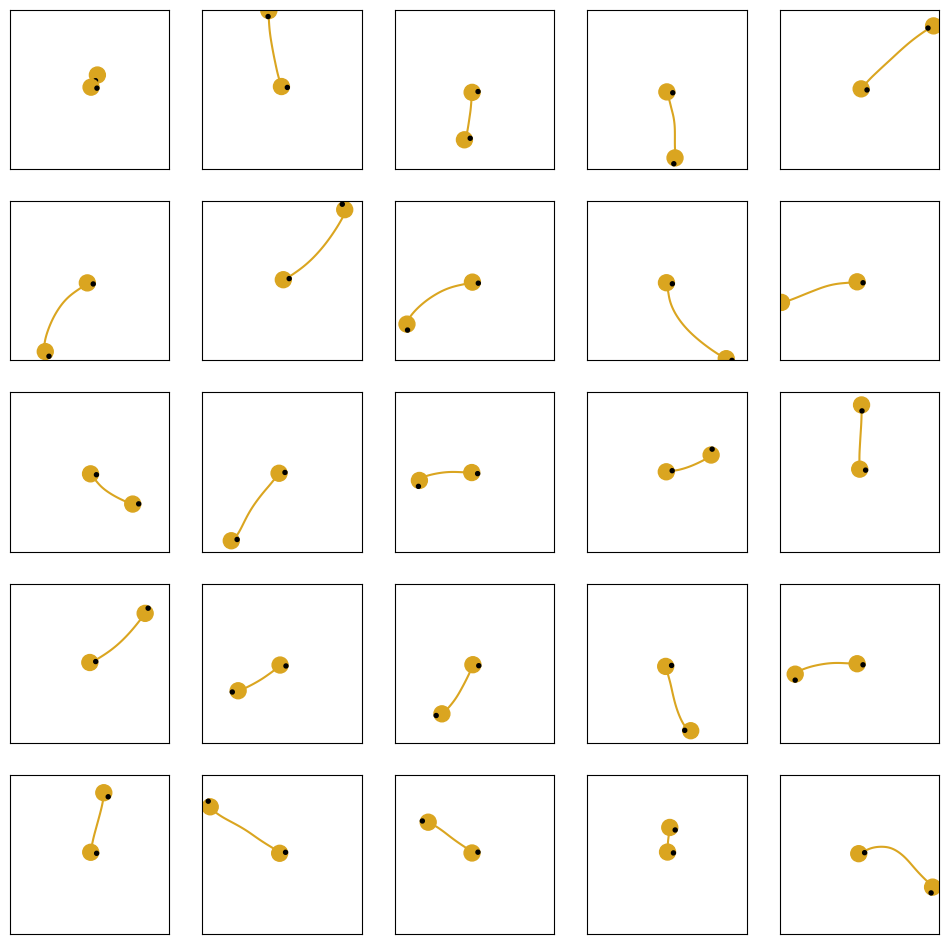

In [22]:
from navground.sim.pyplot_helpers import plot_runs

fig = plot_runs(list(exp.runs.values())[:25],
                columns=5,
                step=100,
                with_agent=True,
                with_world=True,
                world_kwargs={'in_box': True, 'no_ticks': True},
                agent_kwargs={'plot_last_pose': True},
                hide_axes=False,
                width=12)

In [28]:
from navground.learning import io

best_model = SAC.load(path / 'best_model')
io.export_policy_as_behavior(path='Pose/SAC', env=train_env, policy=best_model.policy)